# Illustrating of co-plotting `Split-Gal4` line, `hemibrain` skeleton with flywire dataset

## Step 1: Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import os

In [3]:
import networkx as nx

In [4]:
#flybrains.download_jefferislab_transforms()
#flybrains.download_saalfeldlab_transforms()
#flybrains.register_transforms()

In [5]:
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer

In [6]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC

## Step 2: Get the `Split-Gal4` line and skeletonise it..

## a) Select the `Gal4` line you are interested in  for example, here I choose the line `R65G01` from the `neuronbridge` website [here](https://neuronbridge.janelia.org/search?q=R65G01)

## b) Download the above line as *.nrrd* by following the link to the `virtualflybrain` site like [here](https://v2.virtualflybrain.org/org.geppetto.frontend/geppetto?id=VFB_00023647&i=VFB_00101567,VFB_00023647)

## c) Use the *.nrrd* file in FiJi and skeletonise using the simple image tracer as illustrated in this video [here](https://youtu.be/xdqAb1fC91I)

## d) Save the skeletonised file as *.swc* format and load it as shown below:

In [7]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
BASE_DIR

'/Users/sri/Documents/Python/pyroglancer/pyroglancer'

In [8]:
swc_files = os.path.join(BASE_DIR, 'data/snt_tracings/VFB_00023647_snt_skel-000.swc')

In [9]:
vfb_neuron = navis.read_swc(swc_files, delimiter='\s+',units = 'um')

In [10]:
navis.health_check(vfb_neuron)

Neuron 2a0f972d-3475-4736-bc16-1f2644c6a9e1 seems perfectly fine.


In [11]:
vfb_neuron = navis.graph.clinic.merge_duplicate_nodes(vfb_neuron)

In [12]:
vfb_neuron

,
type,navis.TreeNeuron
name,VFB_00023647_snt_skel-000
n_nodes,1422
n_connectors,None
n_branches,59
n_leafs,61
cable_length,1106.13
soma,None
units,1 micrometer


In [13]:
jrc2018u_mesh = navis.Volume(flybrains.JRC2018U.mesh)

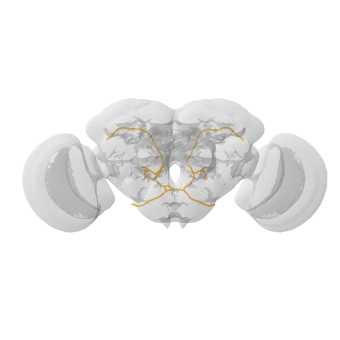

In [14]:
fig, ax = navis.plot2d([vfb_neuron,jrc2018u_mesh],linewidth = 1.5, method='3d_complex')
# Just adjust `azim` (azimuth) and `elev` (elevation) to change view
ax.azim = -90
ax.elev = -90
# Zoom in a bit
ax.dist = 6

## Step 3: Set configurations to fetch from data from `neuprint`

In [15]:
neuprint_token = os.environ['NEUPRINT_APPLICATION_CREDENTIALS']
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.1', token=neuprint_token)
client

Client("https://neuprint.janelia.org", "hemibrain:v1.1")

## Step 4: Get the matching skid from `neuprint` using the info from `neuronbridge` website like [here](https://neuronbridge.janelia.org/search/lines/R65G01/matches/2711776921103892491)

In [16]:
hemibrain_skel = neu.fetch_skeletons(1912789965, heal=1000, max_threads=30)

## Step 5: Transform them to Flywire space..

In [17]:
vfb_neuron=navis.xform_brain(vfb_neuron,source='JRC2018U', target='FLYWIRE')

Transform path: JRC2018U -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


In [18]:
hemibrain2flywire_skel=navis.xform_brain(hemibrain_skel,source='JRCFIB2018Fraw', target='FLYWIRE')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


## Step 6: Start the dataserver to host precomputed data..

In [19]:
startdataserver()

Serving data from:  /var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpu3ci53i4
Serving directory at http://127.0.0.1:8000


## Step 7: Get the url from flywire to append data onto..

In [20]:
shorturl = 'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5169621741076480'
#This flywire segments has some stuff similar (in blue), you will notice their closeness in the final plot

## Step 8: Add bodyids to flywire layers..

In [21]:
vfb_neuron.id = 1234

In [22]:
matchingneurons = navis.NeuronList(vfb_neuron)
matchingneurons += hemibrain2flywire_skel

In [23]:
matchingneurons

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,VFB_00023647_snt_skel-000,1234,1422,NaN,59,61,1.441949e+06,None,0.9999999999999999 nanometer
1,navis.TreeNeuron,VL1_ilPN,1912789965,9322,4466.0,1126,1166,3.367353e+06,None,800.0000000000001 picometer


In [24]:
tmpviewer = add_flywirelayer(flywireurl2dict(shorturl), layer_kws = {'type': 'skeletons',
                                                                     'source': matchingneurons,
                                                                     'color': ['magenta', 'red'],
                                                                     #'space': 'FAFBv14.1',
                                                                     #'annotationstatetype': 'precomputed'
                                                                    }) 
#'alpha': 0.3, doesn't work yet in skeleton layers..

/private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpu3ci53i4/precomputed/skeletons/1234
/private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpu3ci53i4/precomputed/skeletons/1912789965
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpu3ci53i4/precomputed/skeletons/seg_props
{1234: '#ff00ff', 1912789965: '#ff0000'}
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5085761296662528


127.0.0.1 - - [26/Feb/2021 10:59:06] "GET /precomputed/skeletons/info HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 10:59:06] "GET /precomputed/skeletons/1234 HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 10:59:06] "GET /precomputed/skeletons/1912789965 HTTP/1.1" 200 -


# Screenshot of the flywire instance should like below..

### The magenta neuron is the `gal4line` from `vfb` whereas the red neuron is the corresponding match from `hemibrain` according to `neuronbridge` and the green neuron is the corresponding `flywire` segment that is closest match

![alt text](pics/gal4line_hemibrain2flywire.png "Title")

## Step 9: Close the dataserver

In [25]:
closedataserver()

Closing server at http://127.0.0.1:8000
Cleaning directory at /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpu3ci53i4
